# Fish Species Classification
Bu proje, balık görüntülerini sınıflandırmak için bir yapay sinir ağı (ANN) modeli oluşturur. İlk olarak, görüntüler ve etiketler hazırlanarak eğitim ve test setlerine ayrılır. Model, görüntüleri işler ve balık türlerini sınıflandırır. Eğitim sürecinde performans grafikleri oluşturulur ve modelin doğruluğu karışıklık matrisi ve sınıflandırma raporu ile değerlendirilir. Son olarak, Keras Tuner kullanılarak modelin hiperparametreleri optimize edilir.

# Gerekli kütüphanelerin yüklenmesi
Bu kod hücresinde, veri işleme ve görselleştirme için gerekli kütüphaneler yüklenir ve uyarılar gizlenir.

In [2]:
import os
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

warnings.filterwarnings("ignore")

# Veri Yükleme ve DataFrame Oluşturma
Bu kod hücresi, balık görüntülerinin dosya yollarını ve etiketlerini toplayan bir DataFrame oluşturur.

In [3]:
fish_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'
labels, paths = [], []

for dir_name, _, filenames in os.walk(fish_dir):
    for filename in filenames:
        if os.path.splitext(filename)[-1] == '.png' and 'GT' not in dir_name:
            labels.append(os.path.basename(dir_name))
            paths.append(os.path.join(dir_name, filename))

data = pd.DataFrame({'path': paths, 'label': labels})
data.head()

,path,label
0,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
1,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
2,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
3,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
4,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel


# İlk Görüntülerin Görselleştirilmesi
Bu kod hücresi, balık veri setinden örnek görüntüleri rastgele seçip görselleştirir.

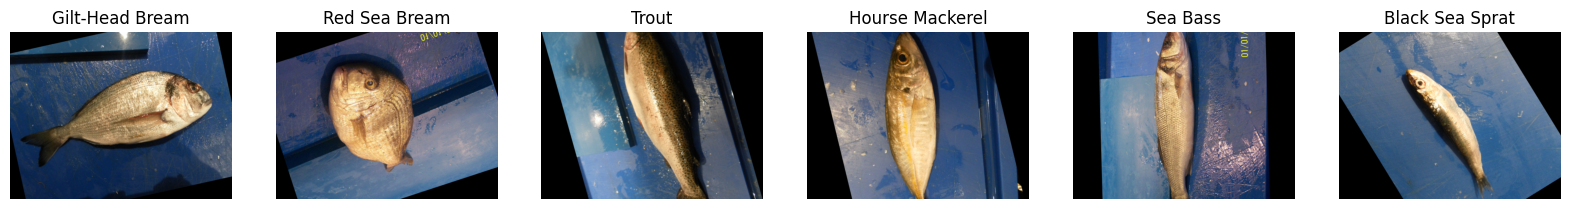

In [4]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

num_samples = 6  
selected_images = []
unique_labels = set()  


while len(selected_images) < num_samples:
    sample = data.sample().iloc[0]
    if sample['label'] not in unique_labels: 
        selected_images.append(sample)
        unique_labels.add(sample['label']) 

fig, axes = plt.subplots(1, len(selected_images), figsize=(20, 4))
for i, sample in enumerate(selected_images):
    img = load_img(sample['path'])  
    axes[i].imshow(img)
    axes[i].set_title(sample['label']) 
    axes[i].axis('off') 

plt.show()

# Veri Setinin Train/Test Olarak Ayrılması
Bu kod hücresi, etiketleri sayısal koda dönüştürerek veriyi eğitim ve test setlerine ayırır.

In [5]:
data['label'] = data['label'].astype('category').cat.codes
X_train, X_test, y_train, y_test = train_test_split(data['path'], data['label'], test_size=0.2, random_state=42)
print(f'Eğitim seti boyutu: {len(X_train)}, Test seti boyutu: {len(X_test)}')

Eğitim seti boyutu: 7200, Test seti boyutu: 1800


# Görüntülerin İşlenmesi (Boyutlandırma ve Normalize Etme)
Bu kod hücresi, görüntü yollarını kullanarak görüntüleri yeniden boyutlandırır, normalize eder ve eğitim ve test setlerine dönüştürür.

In [6]:
img_size = (118, 89)

def preprocess_images(image_paths):
    images = []
    for img_path in image_paths:
        img = load_img(img_path, target_size=img_size)
        img_array = img_to_array(img) / 255.0
        images.append(img_array)
    return np.array(images)

X_train_images = preprocess_images(X_train)
X_test_images = preprocess_images(X_test)

print(f'Eğitim seti şekli: {X_train_images.shape}, Test seti şekli: {X_test_images.shape}')

Eğitim seti şekli: (7200, 118, 89, 3), Test seti şekli: (1800, 118, 89, 3)


# Yapay Sinir Ağı (ANN) Modeli Oluşturma
Bu kod hücresi, basit bir yapay sinir ağı (ANN) modelini tanımlar. Model, görüntüleri düzleştirip iki gizli katman üzerinden sınıflandırma yapar. Çıkış katmanında, sınıf sayısına bağlı olarak softmax aktivasyonu kullanılır.

In [15]:
model = Sequential()
model.add(Flatten(input_shape=(118, 89, 3)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
num_classes = len(data['label'].unique())
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 31506)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     4,032,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,041,737 (15.42 MB)

 Trainable params: 4,041,737 (15.42 MB)

 Non-trainable params: 0 (0.00 B)

# Modelin Eğitilmesi
u kod hücresi, modeli eğitim verileri üzerinde eğitir ve her epoch sonunda test verileri ile doğrulama yaparak modelin performansını izler.

In [11]:
history = model.fit(X_train_images, y_train, 
                    epochs=10, 
                    validation_data=(X_test_images, y_test), 
                    batch_size=32)

Epoch 1/10


I0000 00:00:1729541937.678144    1641 service.cc:145] XLA service 0x7994c4005a00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729541937.678228    1641 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 46/225 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1191 - loss: 4.4233

I0000 00:00:1729541940.077187    1641 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.1235 - loss: 2.9084 - val_accuracy: 0.1361 - val_loss: 2.1603
Epoch 2/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1350 - loss: 2.1618 - val_accuracy: 0.1233 - val_loss: 2.1827
Epoch 3/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1292 - loss: 2.1374 - val_accuracy: 0.1644 - val_loss: 2.0794
Epoch 4/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1498 - loss: 2.1087 - val_accuracy: 0.1933 - val_loss: 2.0226
Epoch 5/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1504 - loss: 2.0837 - val_accuracy: 0.1489 - val_loss: 2.0904
Epoch 6/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1517 - loss: 2.0804 - val_accuracy: 0.1733 - val_loss: 2.0228
Epoch 7/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1454 - loss: 2.0898 - val_accuracy: 0.1800 - val_loss: 1.9470
Epoch 8/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1545 - loss: 2.0755 - val_accuracy: 0.2272 - val

# Eğitim ve Doğrulama Kayıp/Doğruluk Grafikleri
Bu kod hücresi, modelin eğitim sürecindeki kayıp ve doğruluk değerlerini epoch'lara göre çizerek eğitim ve doğrulama performansını görselleştirir.

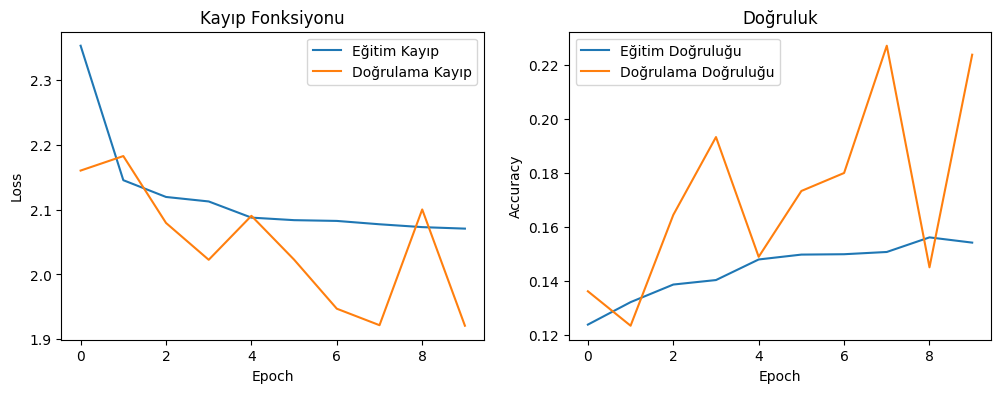

In [12]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Eğitim Kayıp')
plt.plot(history.history['val_loss'], label='Doğrulama Kayıp')
plt.title('Kayıp Fonksiyonu')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Doğruluk')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Confusion Matrix ve Classification Report
Bu kod hücresi, test setindeki gerçek ve tahmin edilen etiketlere dayalı olarak bir karışıklık matrisi oluşturur ve sınıflandırma performansını ölçmek için bir sınıflandırma raporu yazdırır.

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


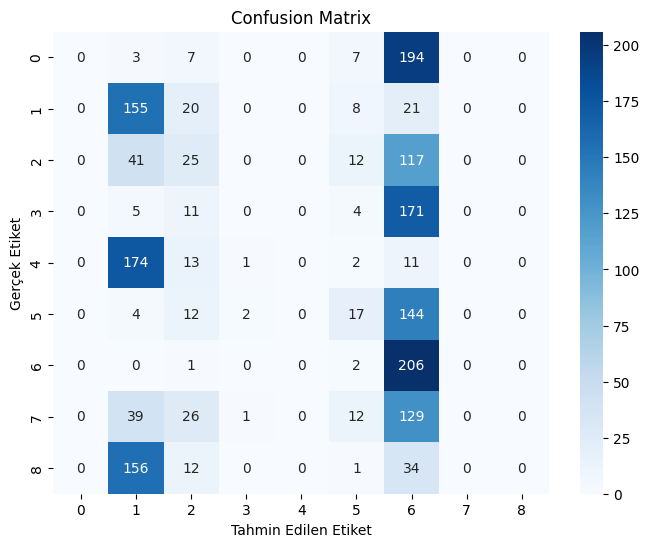

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       211
           1       0.27      0.76      0.40       204
           2       0.20      0.13      0.16       195
           3       0.00      0.00      0.00       191
           4       0.00      0.00      0.00       201
           5       0.26      0.09      0.14       179
           6       0.20      0.99      0.33       209
           7       0.00      0.00      0.00       207
           8       0.00      0.00      0.00       203

    accuracy                           0.22      1800
   macro avg       0.10      0.22      0.11      1800
weighted avg       0.10      0.22      0.11      1800



In [14]:
y_pred = np.argmax(model.predict(X_test_images, batch_size=32), axis=1)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Gerçek Etiket')
plt.xlabel('Tahmin Edilen Etiket')
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred))


# Hiperparametre Optimizasyonu

Bu kod hücresi, modelin hiperparametrelerini (katman birim sayısı, dropout oranları, öğrenme oranı ve optimizer) optimize etmek için `Keras Tuner` kullanır. En iyi hiperparametreleri bulduktan sonra model, bu ayarlarla yeniden eğitili.


In [17]:
import keras_tuner as kt
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    model = Sequential()

    model.add(Flatten(input_shape=(118, 89, 3)))
    
    model.add(Dense(units=hp.Int('units_1', min_value=32, max_value=512, step=32), 
                    activation='relu'))
    
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))
    
    model.add(Dense(units=hp.Int('units_2', min_value=32, max_value=512, step=32), 
                    activation='relu'))
    
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    optimizer = hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd'])
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  
    executions_per_trial=1,  
    directory='hyperparameter_tuning',
    project_name='fish_classification'
)

tuner.search(X_train_images, y_train, epochs=10, validation_data=(X_test_images, y_test))

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"En iyi birinci katman birim sayısı: {best_hps.get('units_1')}")
print(f"En iyi ikinci katman birim sayısı: {best_hps.get('units_2')}")
print(f"En iyi dropout oranı: {best_hps.get('dropout_1')}, {best_hps.get('dropout_2')}")
print(f"En iyi öğrenme oranı: {best_hps.get('learning_rate')}")
print(f"En iyi optimizer: {best_hps.get('optimizer')}")

model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train_images, y_train, epochs=10, validation_data=(X_test_images, y_test))


Trial 5 Complete [00h 00m 16s]
val_accuracy: 0.0994444414973259

Best val_accuracy So Far: 0.8483333587646484
Total elapsed time: 00h 03m 25s
En iyi birinci katman birim sayısı: 384
En iyi ikinci katman birim sayısı: 96
En iyi dropout oranı: 0.1, 0.1
En iyi öğrenme oranı: 0.0001473332769477322
En iyi optimizer: adam
Epoch 1/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.2147 - loss: 4.5162 - val_accuracy: 0.5239 - val_loss: 1.3855
Epoch 2/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4609 - loss: 1.4881 - val_accuracy: 0.5744 - val_loss: 1.1323
Epoch 3/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5767 - loss: 1.2042 - val_accuracy: 0.6661 - val_loss: 0.9365
Epoch 4/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6329 - loss: 1.0488 - val_accuracy: 0.7272 - val_loss: 0.7609
Epoch 5/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6882 - loss: 0.8790 - val_accuracy: 0.7322 - val_loss: 0.7651
Epoch 6/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s

# Nihai Model Değerlendirmesi

Bu kod hücresi, optimize edilmiş modelin eğitim ve doğrulama doğruluklarını çizerek model performansını görselleştirir. Ayrıca, test setindeki tahmin sonuçlarına dayalı olarak karışıklık matrisi ve sınıflandırma raporu oluşturu.


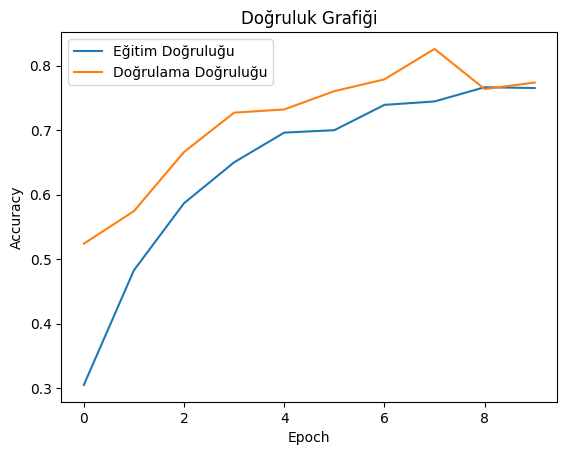

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


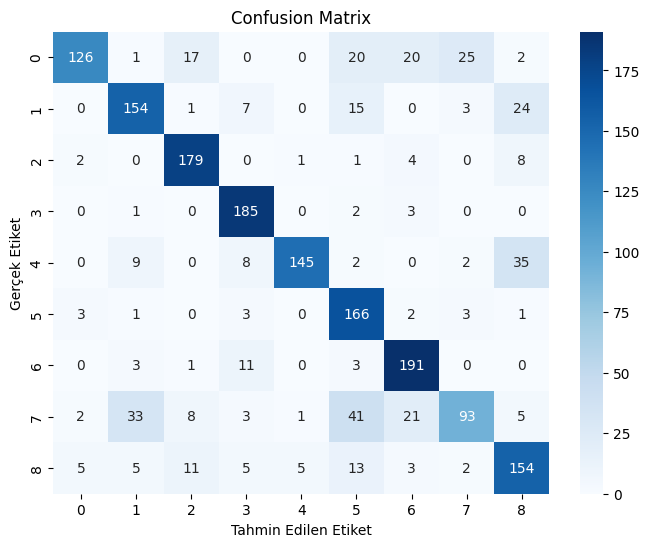

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.60      0.72       211
           1       0.74      0.75      0.75       204
           2       0.82      0.92      0.87       195
           3       0.83      0.97      0.90       191
           4       0.95      0.72      0.82       201
           5       0.63      0.93      0.75       179
           6       0.78      0.91      0.84       209
           7       0.73      0.45      0.56       207
           8       0.67      0.76      0.71       203

    accuracy                           0.77      1800
   macro avg       0.79      0.78      0.77      1800
weighted avg       0.79      0.77      0.77      1800



In [18]:
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Doğruluk Grafiği')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

y_pred = np.argmax(model.predict(X_test_images), axis=1)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Gerçek Etiket')
plt.xlabel('Tahmin Edilen Etiket')
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred))
